# 0 Dataset cleaning and Exploration

## Table of Contents

1. [Loading the Data and Necessary Libraries](#loading-dependencies)
2. [Typecasting](#typecasting)
3. [Filtering Data](#Filtering)
4. [Saving cleaned Dataset](#saving)
6. [Datasetexploration](#Exploration)


## Loading the Data and Libraries 
<a class="anchor" id="loading-dependencies"></a>

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from geopy.geocoders import Nominatim
import reverse_geocode
import json

plt.rc('font', family= 'Times New Roman', size= 14)

df_c = pd.read_csv("NYT_data_2020/nyt-comments-2020.csv",low_memory=False)

## Typecasting 
<a class="anchor" id="typecasting"></a>

In [2]:
df_c.createDate = pd.to_datetime(df_c.createDate)
df_c.updateDate = pd.to_datetime(df_c.updateDate)
df_c.approveDate = pd.to_datetime(df_c.approveDate)

## Filtering data 
<a class="anchor" id="Filtering"></a>

Removieng useres that are affiliated with the NYT (Moderators and Authors)  
as well as dropping not needed rows and columns

In [3]:
df_c = df_c[df_c['userTitle'].isna()] # Selecting only users

df_c.drop('status', axis=1, inplace=True) # Status is always True
df_c.drop('userTitle', axis=1, inplace=True)
df_c.drop('isAnonymous', axis=1, inplace=True)
df_c.drop(['commentSequence','permID'], axis=1, inplace=True) #the commentID, commentSequence & permID are all ideantical and there is no isnatance that deaviates from the rule  
df_c.drop(['trusted','recommendedFlag'], axis=1, inplace=True)

## Saving Comment Cleaned comment dataset
<a class="anchor" id="saving"></a>


In [4]:
df_c = pd.read_parquet('Comments.parquet')

## Dataset Exploration
<a class="anchor" id="Exploration"></a>

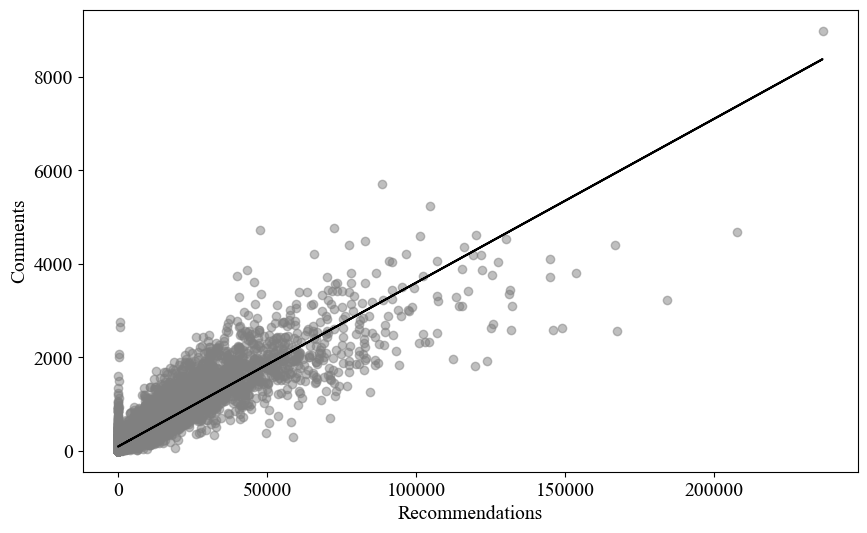

In [5]:
df = df_c.groupby('articleID').agg({
    'recommendations': 'sum',
    'userID': 'nunique',
    'commentID': 'count'})

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df['recommendations'], df['commentID'], alpha=0.5, color='gray')  # Use gray for the points
ax.set_xlabel('Recommendations')
ax.set_ylabel('Comments')
m, b = np.polyfit(df['recommendations'], df['commentID'], 1)
ax.plot(df['recommendations'], m*df['recommendations'] + b, color='black')  # Use black for the trend line

plt.show()

## Plotting the delay between the time of creation and the posts being published



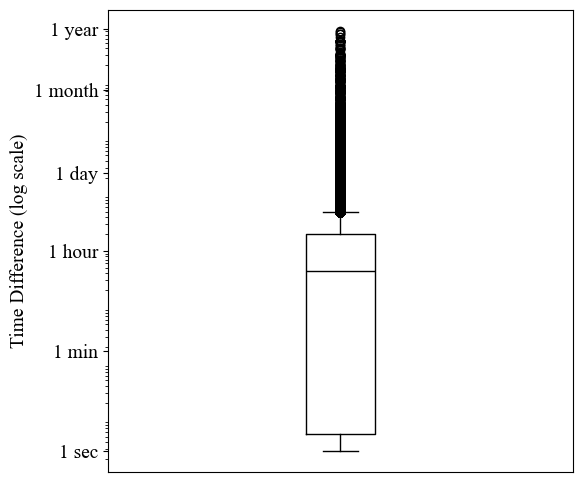

In [7]:
df_c['time_difference'] = pd.to_timedelta(df_c['approveDate'] - df_c['createDate'])
df_c['time_difference_pos'] = (df_c['time_difference'] > pd.Timedelta(hours=0))
dif = df_c[df_c['time_difference_pos']]['time_difference']
dif = dif.dt.total_seconds() / 3600

plt.figure(figsize=(6, 6)) 
box = plt.boxplot(dif, vert=True, patch_artist=False,)

for thing in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(box[thing], color='black')
    
plt.yscale('log')
tick_marks = [1/3600, 1/60, 1, 24, 720, 8760]
tick_labels = ['1 sec', '1 min', '1 hour', '1 day', '1 month', '1 year']

plt.yticks(tick_marks, tick_labels)
plt.ylabel('Time Difference (log scale)')
plt.xticks([])
plt.show()

## Lorenz Plot for Comments per User

Text(0, 0.5, 'Cumulative Share of Comments')

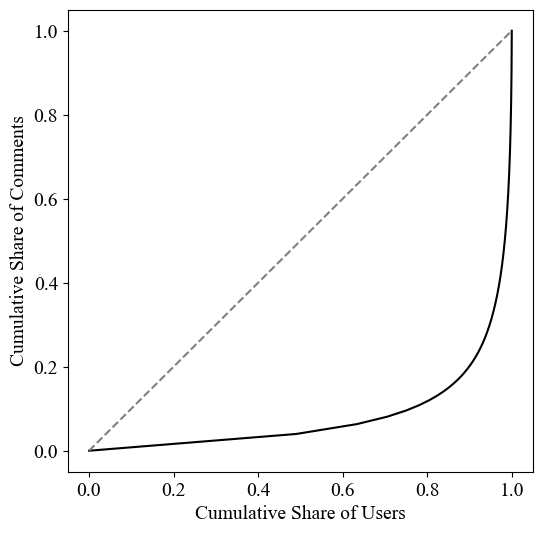

In [14]:
sorted = df_c.groupby(["userID"]).count().sort_values(by=['commentBody'], ascending= False).commentBody.tolist()
sorted = np.sort(sorted)
cumulative_percentage = np.cumsum(sorted) / np.sum(sorted)

plt.figure(figsize=(6, 6))
plt.plot(np.linspace(0, 1, len(cumulative_percentage)), cumulative_percentage, linestyle='-', color='black')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Cumulative Share of Users')
plt.ylabel('Cumulative Share of Comments')

## Plotting the number of comments postet per user

Text(0.5, 0, 'Users ')

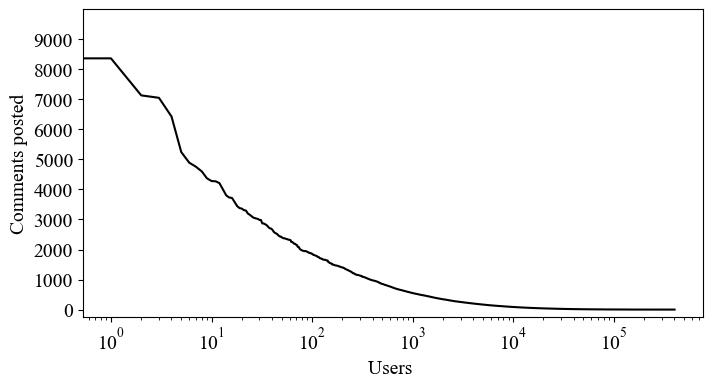

In [15]:
sorted_cc = df_c.groupby(["userID"]).count().sort_values(by=['commentBody'], ascending= False).commentBody.tolist()
plt.figure(figsize=(8, 4))
plt.plot(sorted_cc,color="black")
plt.xscale("log")

plt.ylim(-250, 10000)
plt.yticks(np.arange(0, 10000, step=1000))
plt.ylabel("Comments posted")
plt.xlabel("Users ")

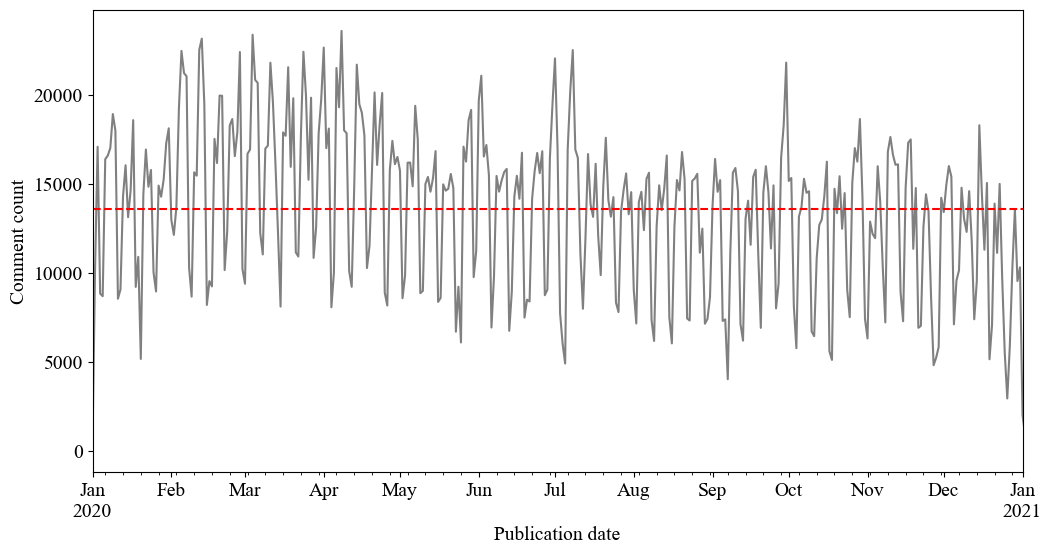

In [10]:
df_p = df_c.set_index('createDate').groupby(pd.Grouper(freq='D')).count().reset_index()
start_date = "2020-01-01"
end_date = "2021-01-01"

mean_comment_count = df_p[(df_p['createDate'] >= pd.to_datetime(start_date)) & (df_p['createDate'] <= pd.to_datetime(end_date))]['commentID'].mean()
ax = df_p.plot(x="createDate", y="commentID",
               xlabel="Publication date",
               ylabel="Comment count",
               xlim=["2020-01-01 00:00:00+00:00", "2021-01-01 00:00:00+00:00"],
               color='gray',
               legend=False,
               figsize=(12, 6))
ax.axhline(y=mean_comment_count, color='red', linestyle='--')
plt.show()

## Plotting the time of the comments hve been posted 

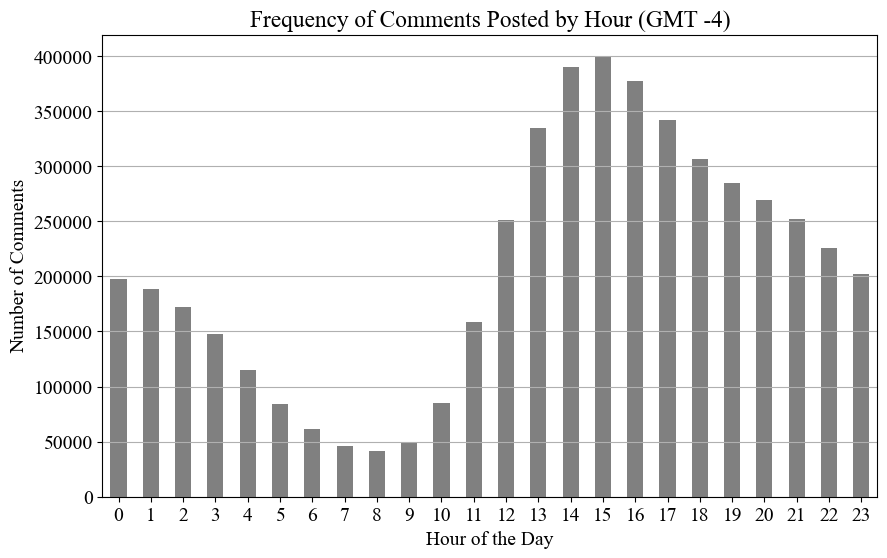

In [11]:
df_c['hour'] = df_c['createDate'].dt.hour
plt.figure(figsize=(10, 6))
df_c['hour'].value_counts().sort_index().plot(kind='bar',color='gray')

plt.title('Frequency of Comments Posted by Hour (GMT -4)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Comments')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

## PLotting top-40 self reported User Locations

Due to variations in the spelling of locations it doesnt provide a reliable insights.


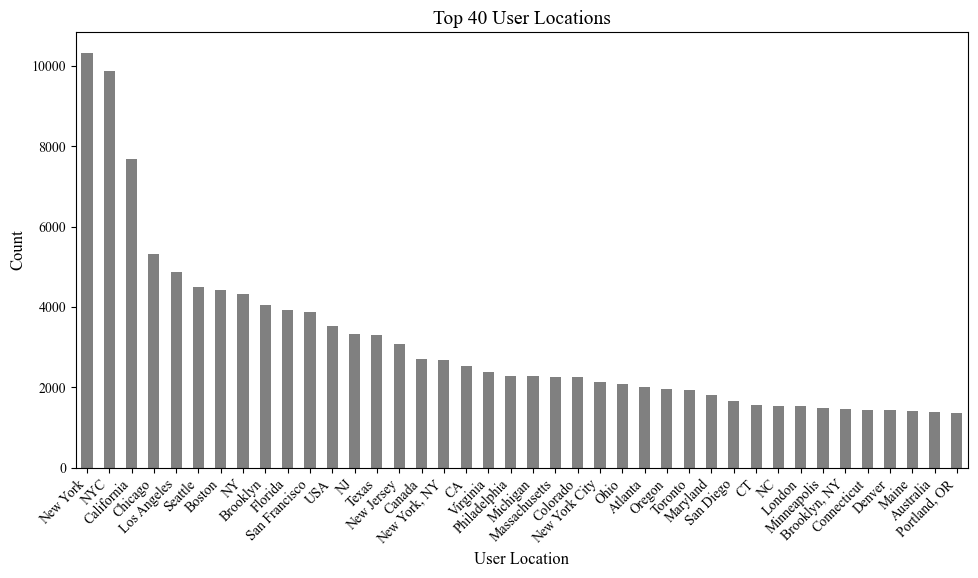

In [12]:
plt.figure(figsize=(10, 6))
df_c.drop_duplicates(subset=["userID"], keep='last')['userLocation'].value_counts().head(40).plot(kind='bar', color='gray')
plt.title('Top 40 User Locations', fontsize=14)
plt.xlabel('User Location', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.yticks(fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()

## Attempt to identify countries from self reported locations

With the help of teh geopy API it is attempted to identyfy the Country of origin of the user, through te self reported location.


In [ ]:
tqdm.pandas()
geolocator = Nominatim(user_agent="Master_Thesis_LEO")

try:
    with open('location_country_dict_backup.json', 'r') as fp:
        location_country_dict = json.load(fp)
except FileNotFoundError:
    location_country_dict = {}

def get_continent(location_name):
    if location_name in location_country_dict:
        return location_country_dict[location_name]
    
    time.sleep(1.5)
    location = geolocator.geocode(location_name)
    if location:
        coordinates = (location.latitude, location.longitude)
        address = reverse_geocode.search([coordinates])[0]
        country = address['country']
        location_country_dict[location_name] = country

        with open('location_country_dict_backup.json', 'w') as fp:
            json.dump(location_country_dict, fp)

        return country
    return None

df_locations = pd.DataFrame(df_c.drop_duplicates(subset=["userID"], keep='last')['userLocation'].value_counts())
df_locations = df_locations.loc[df_locations["count"] > 5]
df_locations = df_locations.reset_index()

df_locations["country"] = df_locations["userLocation"].progress_apply(get_continent)
df_locations.to_csv('locations_with_countries.csv', index=False)

with open('location_country_dict.json', 'w') as fp:
    json.dump(location_country_dict, fp)

df_locations
df_locations.to_parquet('countrys.parquet')

In [16]:
df_locations = pd.read_parquet('countrys.parquet')
df_all = df_c.merge(df_locations, left_on='userLocation', right_on='userLocation')

## Top 10 User Countries of Origin (%)

In [17]:
location_counts = df_locations.country.value_counts(normalize=True).head(10) * 100
location_counts

country
United States     77.059543
Canada             3.323817
United Kingdom     1.814845
Australia          1.060359
Italy              0.876835
France             0.856444
Germany            0.774878
India              0.754486
Spain              0.652529
Philippines        0.469005
Name: proportion, dtype: float64

## Top 30 Comment Countries of Origin (%)

In [18]:
df_all.country.value_counts(normalize=True).head(30) * 100

country
United States                       82.779456
Canada                               4.076010
Australia                            1.176792
United Kingdom                       1.015507
Spain                                0.911635
Germany                              0.595525
Panama                               0.568851
France                               0.562945
Colombia                             0.545053
Morocco                              0.522567
Italy                                0.517545
Netherlands                          0.406380
New Zealand                          0.371629
Lao People's Democratic Republic     0.288779
India                                0.269321
Central African Republic             0.242899
Israel                               0.239391
Cameroon                             0.238457
Holy See (Vatican City State)        0.211051
Moldova, Republic of                 0.210395
Iran, Islamic Republic of            0.194395
Mongolia                  